In [ ]:
#This chapter looks at ARMA model, and limitations of ACF and PACF. 
#Also looks at the Akaike Information Criterion (AIC) for model selection

In [3]:
import numpy as np 
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [48]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [27]:
from statsmodels.graphics.gofplots import qqplot

In [2]:
df = pd.read_csv('bandwidth.csv')
df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


In [4]:
adf_res = adfuller(df['hourly_bandwidth'])

print(f'ADF Stat: {adf_res[0]}')
print(f'p-value: {adf_res[1]}')

ADF Stat: -0.871465319945285
p-value: 0.7972240255014513


In [7]:
# so we need to diff it 

bandwidth_diff = np.diff(df['hourly_bandwidth'], n=1)

In [8]:
adf_res = adfuller(bandwidth_diff)

print(f'ADF Stat: {adf_res[0]}')
print(f'p-value: {adf_res[1]}')

ADF Stat: -20.694853863789053
p-value: 0.0


In [9]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff}) 

train = df_diff[:-168] 
test = df_diff[-168:] 

print(len(train)) 
print(len(test))



9831
168


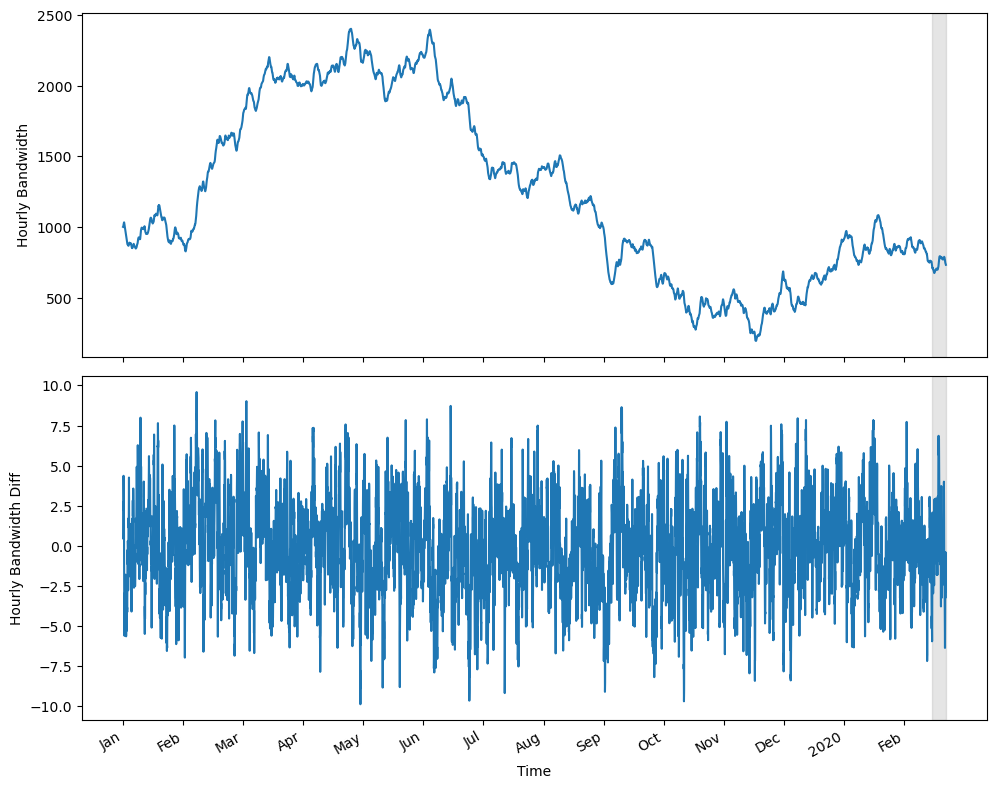

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2,  ncols=1, sharex=True, figsize=(10,8)) 

ax1.plot(df.hourly_bandwidth) 
ax1.set_xlabel('Time') 
ax1.set_ylabel('Hourly Bandwidth') 
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2) 

ax2.plot(df_diff.bandwidth_diff) 
ax2.set_xlabel('Time') 
ax2.set_ylabel('Hourly Bandwidth Diff') 
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2) 

plt.xticks( 
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate() 
plt.tight_layout()



In [13]:
from typing import Union 
from tqdm import tqdm_notebook 
from statsmodels.tsa.statespace.sarimax import SARIMAX 

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame: 
    results = [] 

    for order in tqdm_notebook(order_list): 
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False) 
        
        except: 
            continue 

        aic = model.aic 
        results.append([order, aic]) 

    result_df = pd.DataFrame(results) 
    result_df.columns = ['(p,q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True) 


    return result_df


In [14]:
from itertools import product

In [15]:
ps = range(0, 4, 1) 
qs = range(0, 4, 1) 

order_list = list(product(ps, qs)) 


In [16]:
result_df = optimize_ARMA(train['bandwidth_diff'], order_list) 
result_df

C:\Users\ibra6\AppData\Local\Temp\ipykernel_31700\1390391140.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


In [17]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Sat, 14 Sep 2024   AIC                          27991.604
Time:                        12:31:40   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

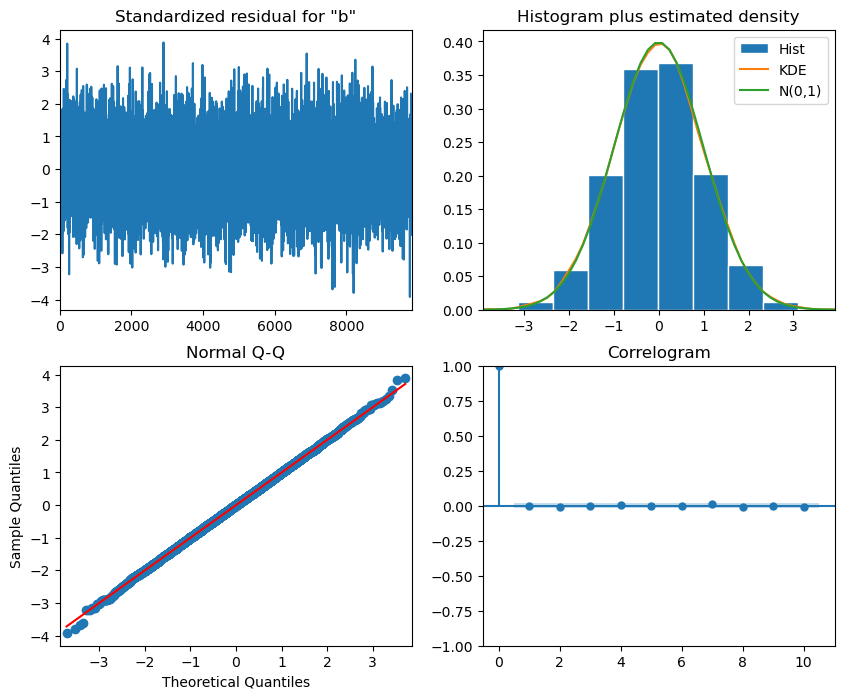

In [18]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [49]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1)) 


In [51]:
residuals

0       0.472694
1       0.635620
2       1.496589
3      -0.140353
4      -0.266030
          ...   
9826   -0.639391
9827    0.498229
9828   -0.666028
9829   -1.042920
9830   -0.854352
Length: 9831, dtype: float64

In [50]:
print(pvalue)

lb_pvalue


In [52]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list: 
    total_len = train_len + horizon 
    end_idx = train_len 

    if method == 'mean': 
        pred_mean = [] 
        
        for i in range(train_len, total_len, window): 
            mean = np.mean(df[:i].values) 
            pred_mean.extend(mean for _ in range(window)) 

        return pred_mean 
    elif method == 'last': 
        pred_last_value = []

        for i in range(train_len, total_len, window):

            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method =='ARMA': 
        pred_ARMA = [] 

        for i in range(train_len, total_len, window): 
            model = SARIMAX(df[:i], order=(2, 0, 2)) 
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1) 
            oos_pred = predictions.predicted_mean.iloc[-window:] 
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [53]:
pred_df = test.copy() 

TRAIN_LEN = len(train) 
HORIZON = len(test) 
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean') 
pred_last = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last') 
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA') 

test.loc[:, 'pred_mean'] = pred_mean 
test.loc[:, 'pred_last'] = pred_last
test.loc[:, 'pred_ARMA'] = pred_ARMA

pred_df.head()


,bandwidth_diff
9831,-5.943995
9832,-5.865194
9833,-3.197066
9834,-1.090197
9835,0.665291


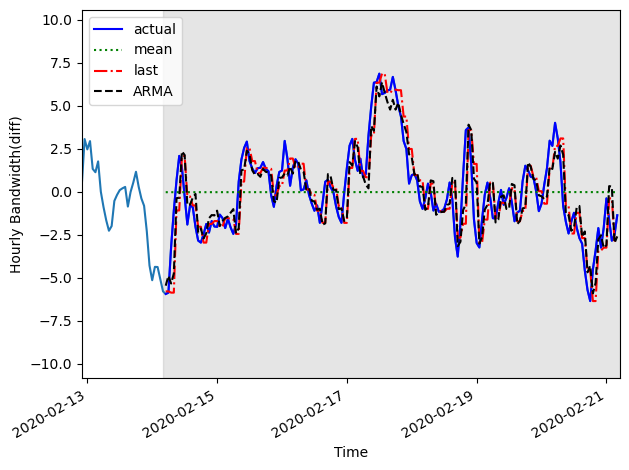

In [57]:
fig, ax = plt.subplots() 

ax.plot(df_diff['bandwidth_diff']) 
ax.plot(test['bandwidth_diff'], 'b-', label='actual') 
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last'], 'r-.', label='last') 
ax.plot(test['pred_ARMA'], 'k--', label='ARMA') 
ax.legend(loc=2)
ax.set_xlabel('Time') 
ax.set_ylabel('Hourly Bandwidth(diff)') 

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate() 
plt.tight_layout()